# R1.1: **Single product and stochastic environment**: No BUDGET

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### BUYER: User

In [13]:
class Buyer:
  def __init__(self, value_distribution=(0, 1)):
    """
    Represents a single buyer that draws a new valuation at each round.
    :param value_distribution: Tuple defining the support of the uniform distribution.
    """
    self.low, self.high = value_distribution

  def round(self, price):
    """
    Generates a random valuation and decides whether to buy at the given price.
    :param price: Offered price
    :return: Reward (price if buyer accepts, 0 otherwise)
    """
    valuation = np.random.uniform(self.low, self.high)
    return price if price < valuation else 0

ADVERTISER: Company
----

single ptoduct

In [14]:
class CompanyUCB1:
  def __init__(self, price_set, T, range_factor=1):
    """
    Implements UCB1 algorithm for dynamic pricing.
    :param price_set: List of possible prices (arms)
    :param T: Time horizon (total rounds)
    :param range_factor: UCB confidence range multiplier
    """
    self.P = price_set
    self.K = len(price_set)  # Number of price options
    self.T = T
    self.range = range_factor

    self.t = 0  # Current time step
    self.p_t = None  # Index of chosen price at time t

    self.average_rewards = np.zeros(self.K)
    self.N_pulls = np.zeros(self.K)  # Count of times each price has been used

  def set_price(self):
    """
    Selects a price using the UCB1 strategy.
    :return: Index of the selected price
    """
    if self.t < self.K:
      # Try each price once initially
      self.p_t = self.t
    else:
      # Compute UCB for each arm
      ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
      self.p_t = np.argmax(ucbs)
    return self.p_t

  def update(self, reward):
    """
    Updates reward and pull count for the selected price.
    :param reward: Observed reward from the environment
    """
    self.N_pulls[self.p_t] += 1
    n = self.N_pulls[self.p_t]
    # Update average using incremental formula
    self.average_rewards[self.p_t] += (reward - self.average_rewards[self.p_t]) / n
    self.t += 1

### ENVIRONMENT: Auction


Best price (expected): 0.50
Expected clairvoyant total reward: 2500.00


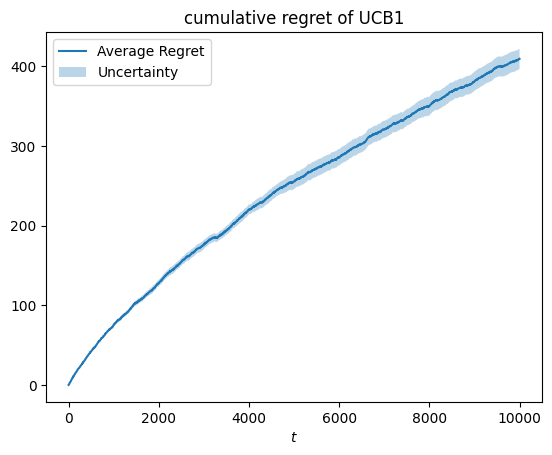

In [15]:
# Price grid and total rounds
P = np.linspace(0, 1, 11)
T = 10000

# Expected demand under Uniform[0, 1] --> Pr[valuation > p] = 1 - p
conversion_probability = lambda p: 1 - p

# Expected reward for each price
expected_rewards = P * conversion_probability(P)  # = p * (1 - p)

# Best expected price and profit
best_price_index = np.argmax(expected_rewards)
best_price = P[best_price_index]
expected_clairvoyant_reward = expected_rewards[best_price_index] * T
expected_clairvoyant_rewards = np.repeat(expected_rewards[best_price_index], T)

print(f"Best price (expected): {best_price:.2f}")
print(f"Expected clairvoyant total reward: {expected_clairvoyant_reward:.2f}")

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
  np.random.seed(seed)

  buyer = Buyer()
  agent = CompanyUCB1(P, T)
  agent_rewards = np.array([])

  for _ in range(T):
    idx = agent.set_price()
    selected_price = agent.P[idx]
    reward = buyer.round(selected_price)

    agent.update(reward)
    agent_rewards = np.append(agent_rewards, reward)

  cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret - regret_std / np.sqrt(n_trials),
                average_regret + regret_std / np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

Remarks
---

- SUBLINEAR REGRET ACHEIVED
- REGRET OF $T^{2/3}$  ACHEIVED

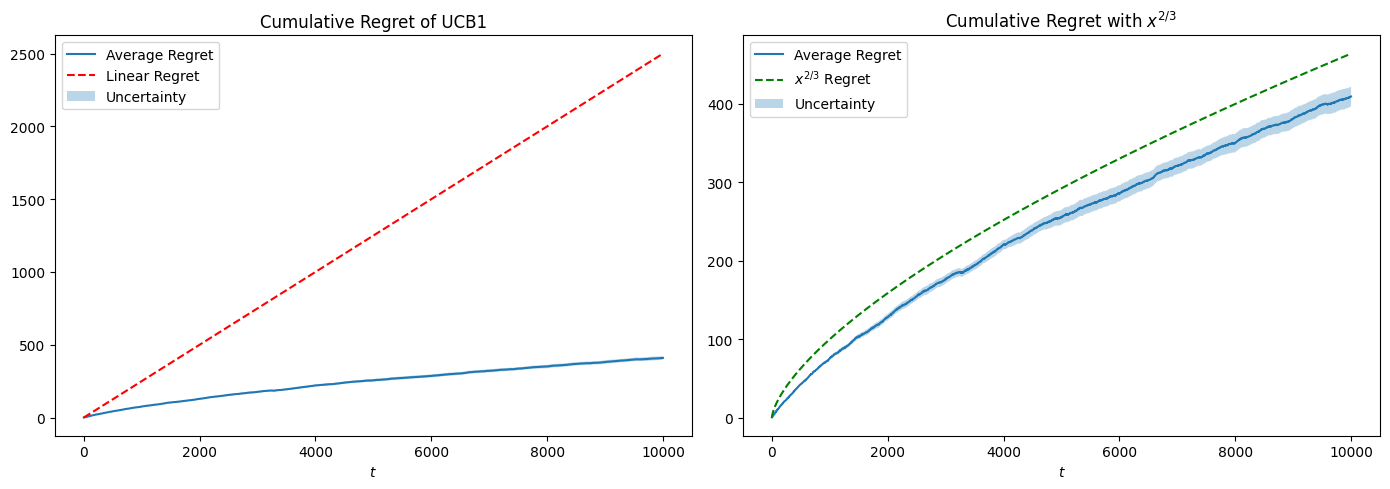

In [20]:
fig, axs = plt.subplots(1,2, figsize=(14 , 5))

# First subplot: Cumulative regret with linear line
axs[0].plot(np.arange(T), average_regret, label='Average Regret')
axs[0].set_title('Cumulative Regret of UCB1')

linear_regret = np.arange(T) * (expected_clairvoyant_reward / T)
axs[0].plot(np.arange(T), linear_regret, label='Linear Regret', linestyle='--', color='red')

axs[0].fill_between(np.arange(T),
                    average_regret - regret_std / np.sqrt(n_trials),
                    average_regret + regret_std / np.sqrt(n_trials),
                    alpha=0.3,
                    label='Uncertainty')

axs[0].set_xlabel('$t$')
axs[0].legend()

# Second subplot: Cumulative regret with x^(2/3) line
axs[1].plot(np.arange(T), average_regret, label='Average Regret')
axs[1].set_title('Cumulative Regret with $x^{2/3}$')

x_2_3_regret = np.arange(T) ** (2/3)
axs[1].plot(np.arange(T), x_2_3_regret, label='$x^{2/3}$ Regret', linestyle='--', color='green')

axs[1].fill_between(np.arange(T),
                    average_regret - regret_std / np.sqrt(n_trials),
                    average_regret + regret_std / np.sqrt(n_trials),
                    alpha=0.3,
                    label='Uncertainty')

axs[1].set_xlabel('$t$')
axs[1].legend()

plt.tight_layout()
plt.show()